<h1>Importing Libraries</h1>

In [1]:
import os
import gc
import re

import cv2
import math
import numpy as np
import scipy as sp
import pandas as pd

import tensorflow as tf
from IPython.display import SVG
from keras.utils import plot_model
import tensorflow.keras.layers as L
from keras.utils import model_to_dot
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from kaggle_datasets import KaggleDatasets
from tensorflow.keras.applications import DenseNet201, InceptionV3, ResNet50V2, InceptionResNetV2

import seaborn as sns
from tqdm import tqdm
import matplotlib.cm as cm
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

tqdm.pandas()
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

np.random.seed(0)
tf.random.set_seed(0)

import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.7/site-packages/tqdm/std.py:666: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


<h1>Loading data</h1>

In [2]:
EPOCHS = 20
SAMPLE_LEN = 100
IMAGE_PATH = "../input/plant-pathology-2020-fgvc7/images"
TEST_PATH = "../input/plant-pathology-2020-fgvc7/test.csv"
TRAIN_PATH = "../input/plant-pathology-2020-fgvc7/train.csv"
SUB_PATH = "../input/plant-pathology-2020-fgvc7/sample_submission.csv"

sub = pd.read_csv(SUB_PATH)
test_data = pd.read_csv(TEST_PATH)
train_data = pd.read_csv(TRAIN_PATH)

In [4]:
print(train_data.shape)
print(test_data.shape)

(1821, 5)
(1821, 1)


In [5]:
train_data.head()

image_id  healthy  multiple_diseases  rust  scab
0  Train_0        0                  0     0     1
1  Train_1        0                  1     0     0
2  Train_2        1                  0     0     0
3  Train_3        0                  0     1     0
4  Train_4        1                  0     0     0

In [6]:
test_data.head()

image_id
0   Test_0
1   Test_1
2   Test_2
3   Test_3
4   Test_4

<h1>EDA</h1>

<h2>Class distributions</h2>

In [31]:
fig = go.Figure(data=[
    go.Pie(labels=train_data.columns[1:],
           values=train_data.iloc[:, 1:].sum().values)
])
fig.show()

<h2>Image Examples</h2>

In [21]:
#Function for showing image
def show_images(image_ids):
    
    col = 5
    row = min(len(image_ids) // col, 5)
    
    fig, ax = plt.subplots(row, col, figsize=(16, 8))
    ax = ax.flatten()

    for i, image_id in enumerate(image_ids):
        image = cv2.imread(IMAGE_PATH + '/{}.jpg'.format(image_id))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        ax[i].set_axis_off()
        ax[i].imshow(image)
        ax[i].set_title(image_id)

<h3>Random samples</h3>

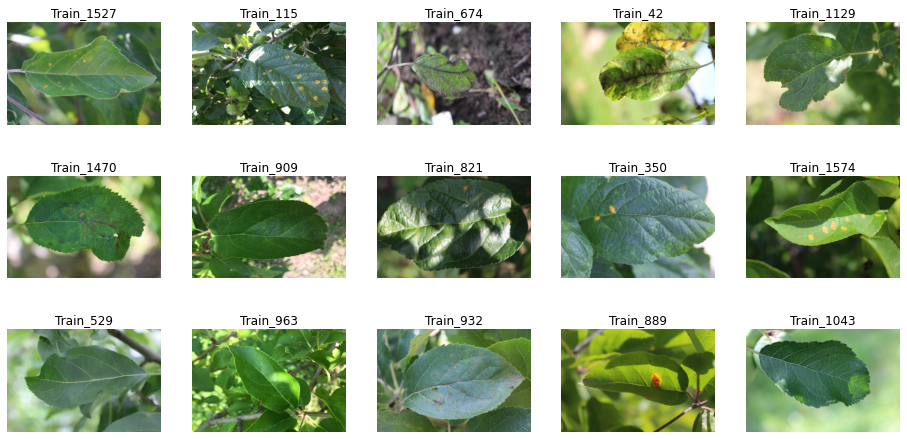

In [23]:
show_images(train_data.sample(n=15)['image_id'].values)

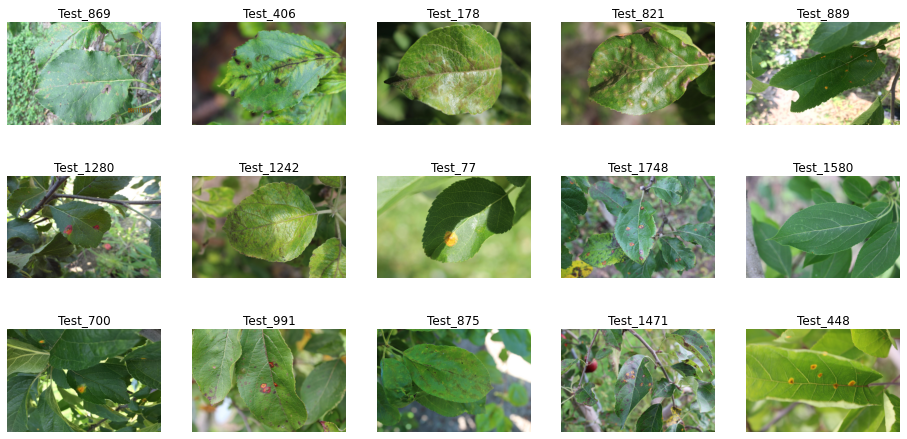

In [25]:
show_images(test_data.sample(n=15)['image_id'].values)

<h3>Healthy</h3>

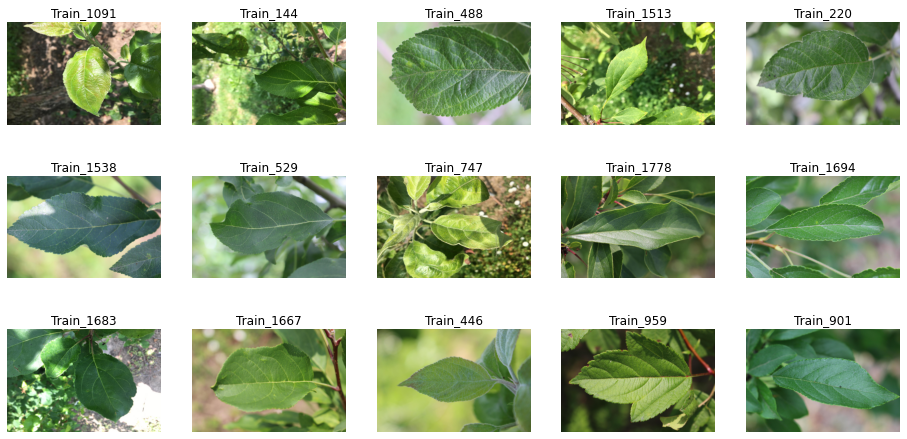

In [26]:
show_images(train_data[train_data['healthy'] == 1].sample(n=15)['image_id'].values)

<h3>Rust</h3>

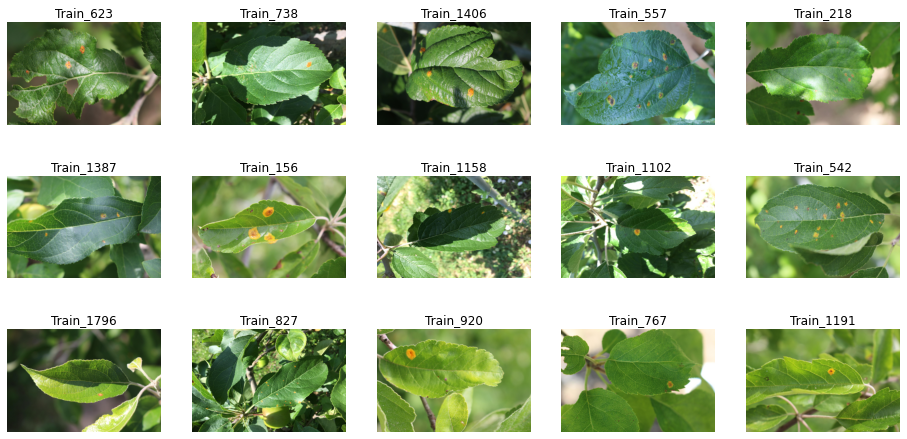

In [28]:
show_images(train_data[train_data['rust'] == 1].sample(n=15)['image_id'].values)


<h3>Scab</h3>

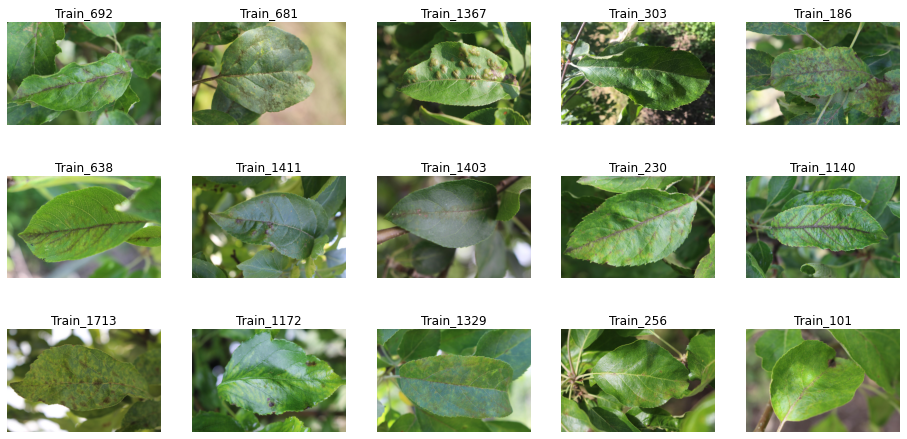

In [29]:
show_images(train_data[train_data['scab'] == 1].sample(n=15)['image_id'].values)

<h3>Multiple Diseases</h3>

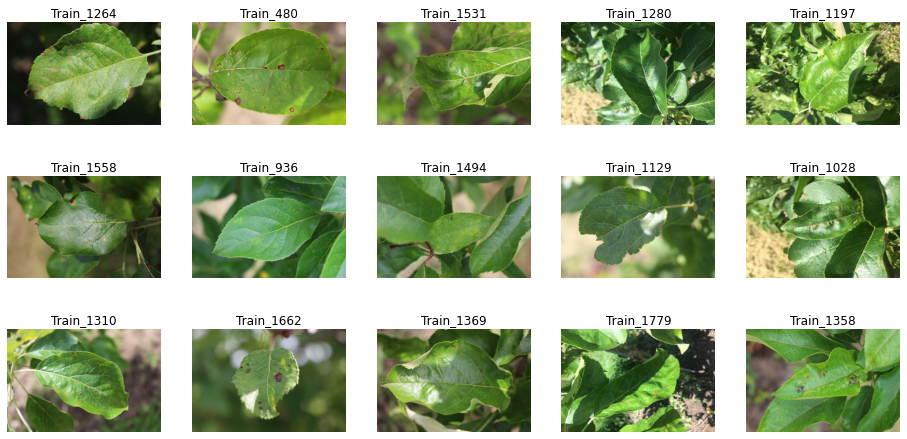

In [30]:
show_images(train_data[train_data['multiple_diseases'] == 1].sample(n=15)['image_id'].values)

<h1>Setup TPU Config</h1>

In [32]:
AUTO = tf.data.experimental.AUTOTUNE
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
strategy = tf.distribute.experimental.TPUStrategy(tpu)

BATCH_SIZE = 16 * strategy.num_replicas_in_sync
GCS_DS_PATH = KaggleDatasets().get_gcs_path()

<h1>Load labels and paths</h1>

In [33]:
def format_path(st):
    return GCS_DS_PATH + '/images/' + st + '.jpg'

test_paths = test_data.image_id.apply(format_path).values
train_paths = train_data.image_id.apply(format_path).values

train_labels = np.float32(train_data.loc[:, 'healthy':'scab'].values)
train_paths, valid_paths, train_labels, valid_labels =\
train_test_split(train_paths, train_labels, test_size=0.15, random_state=42)

In [34]:
def decode_image(filename, label=None, image_size=(512, 512)):
    bits = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(bits, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.resize(image, image_size)
    
    if label is None:
        return image
    else:
        return image, label

def data_augment(image, label=None): # Data augmentations
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_saturation(image, 0.7, 1.3)
    image = tf.image.random_contrast(image, 0.8, 1.2)
    imgae = tf.image.random_brightness(image, 0.1)
    
    if label is None:
        return image
    else:
        return image, label

<h1>Creating Dataset objects</h1>

In [35]:
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((train_paths, train_labels))
    .map(decode_image, num_parallel_calls=AUTO)
    .map(data_augment, num_parallel_calls=AUTO)
    .repeat()
    .shuffle(512)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((valid_paths, valid_labels))
    .map(decode_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)

test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(test_paths)
    .map(decode_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
)

<h1>Defining Learning-Rate Scheduler</h1>

In [36]:
def build_lrfn(lr_start=0.00001, lr_max=0.00005, 
               lr_min=0.00001, lr_rampup_epochs=5, 
               lr_sustain_epochs=0, lr_exp_decay=.8):
    lr_max = lr_max * strategy.num_replicas_in_sync

    def lrfn(epoch):
        if epoch < lr_rampup_epochs:
            lr = (lr_max - lr_start) / lr_rampup_epochs * epoch + lr_start
        elif epoch < lr_rampup_epochs + lr_sustain_epochs:
            lr = lr_max
        else:
            lr = (lr_max - lr_min) *\
                 lr_exp_decay**(epoch - lr_rampup_epochs\
                                - lr_sustain_epochs) + lr_min
        return lr
    return lrfn

<h1>Defining hyperparameters of fit</h1>

In [37]:
lrfn = build_lrfn()
STEPS_PER_EPOCH = train_labels.shape[0] // BATCH_SIZE
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=1)

<h1>Function for visualizing training and validation accuracy</h1>

In [38]:
def display_training_curves(training, validation, yaxis):
    if yaxis == "loss":
        ylabel = "Loss"
        title = "Loss vs. Epochs"
    else:
        ylabel = "Accuracy"
        title = "Accuracy vs. Epochs"
        
    fig = go.Figure()
        
    fig.add_trace(
        go.Scatter(x=np.arange(1, EPOCHS+1), mode='lines+markers', y=training, marker=dict(color="dodgerblue"),
               name="Train"))
    
    fig.add_trace(
        go.Scatter(x=np.arange(1, EPOCHS+1), mode='lines+markers', y=validation, marker=dict(color="darkorange"),
               name="Val"))
    
    fig.update_layout(title_text=title, yaxis_title=ylabel, xaxis_title="Epochs", template="plotly_white")
    fig.show()

<h1>Modelling</h1>

<h2>1. DenseNet</h2>

In [39]:
#Setting the model to train in TPU
with strategy.scope():
    model = tf.keras.Sequential([DenseNet201(input_shape=(512, 512, 3),
                                             weights='imagenet',
                                             include_top=False),
                                 L.GlobalAveragePooling2D(),
                                 L.Dense(train_labels.shape[1],
                                         activation='softmax')])
        
    model.compile(optimizer='adam',
                  loss = 'categorical_crossentropy',
                  metrics=['categorical_accuracy'])
    model.summary()

74842112/74836368 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Model)          (None, 16, 16, 1920)      18321984  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1920)              0         
_________________________________________________________________
dense (Dense)                (None, 4)                 7684      
Total params: 18,329,668
Trainable params: 18,100,612
Non-trainable params: 229,056
_________________________________________________________________


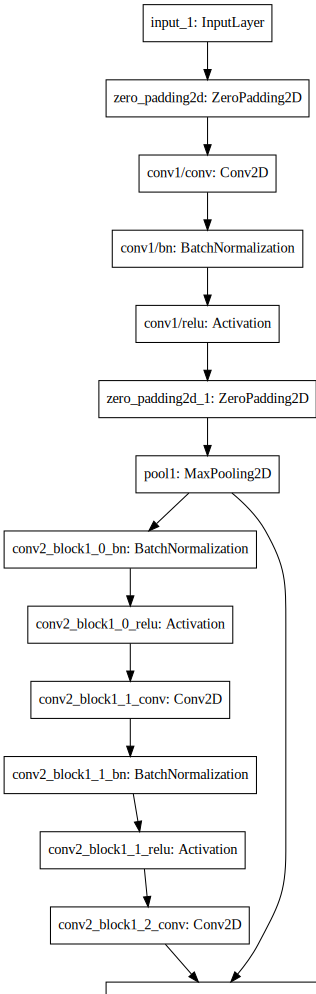

In [40]:
#Fundamental Block
SVG(tf.keras.utils.model_to_dot(Model(model.layers[0].input, model.layers[0].layers[13].output), dpi=70).create(prog='dot', format='svg'))

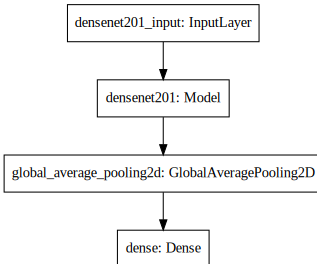

In [41]:
#Model Architecture
SVG(tf.keras.utils.model_to_dot(model, dpi=70).create(prog='dot', format='svg'))

In [42]:
#Training
history = model.fit(train_dataset,
                    epochs=EPOCHS,
                    callbacks=[lr_schedule],
                    steps_per_epoch=STEPS_PER_EPOCH,
                    validation_data=valid_dataset)


Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/20
12/12 [==============================] - 69s 6s/step - loss: 1.2394 - categorical_accuracy: 0.3965 - val_loss: 1.2560 - val_categorical_accuracy: 0.4453 - lr: 1.0000e-05

Epoch 00002: LearningRateScheduler reducing learning rate to 8.8e-05.
Epoch 2/20
12/12 [==============================] - 16s 1s/step - loss: 0.6269 - categorical_accuracy: 0.7923 - val_loss: 1.2454 - val_categorical_accuracy: 0.4270 - lr: 8.8000e-05

Epoch 00003: LearningRateScheduler reducing learning rate to 0.000166.
Epoch 3/20
12/12 [==============================] - 33s 3s/step - loss: 0.2708 - categorical_accuracy: 0.9069 - val_loss: 2.6343 - val_categorical_accuracy: 0.3869 - lr: 1.6600e-04

Epoch 00004: LearningRateScheduler reducing learning rate to 0.000244.
Epoch 4/20
12/12 [==============================] - 33s 3s/step - loss: 0.1735 - categorical_accuracy: 0.9486 - val_loss: 1.0637 - val_categorical_accuracy: 0.7336 - lr: 2.4

In [43]:
#Visualizing train and valid accuracy
display_training_curves(
    history.history['categorical_accuracy'], 
    history.history['val_categorical_accuracy'], 
    'accuracy')

In [44]:
#Prediction
probs_dnn = model.predict(test_dataset, verbose=1)
sub.loc[:, 'healthy':] = probs_dnn
sub.to_csv('submission_dnn.csv', index=False)
sub.head()

#LB:0.96792

15/15 [==============================] - 46s 3s/step


image_id       healthy  multiple_diseases          rust          scab
0   Test_0  2.140607e-05       7.088479e-04  9.992692e-01  5.670687e-07
1   Test_1  1.286521e-06       8.552525e-04  9.991434e-01  1.326307e-07
2   Test_2  6.787174e-08       1.291509e-07  3.281687e-08  9.999998e-01
3   Test_3  9.998174e-01       2.350606e-06  1.798725e-04  3.232674e-07
4   Test_4  2.400135e-09       2.693805e-05  9.999731e-01  2.215879e-09

<h2>2. InceptionV3</h2>

In [45]:
with strategy.scope():
    model = tf.keras.Sequential([InceptionV3(input_shape=(512, 512, 3),
                                             weights='imagenet',
                                             include_top=False),
                                 L.GlobalAveragePooling2D(),
                                 L.Dense(train_labels.shape[1],
                                         activation='softmax')])
        
    model.compile(optimizer='adam',
                  loss = 'categorical_crossentropy',
                  metrics=['categorical_accuracy'])
    model.summary()

87916544/87910968 [==============================] - 2s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 14, 14, 2048)      21802784  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 8196      
Total params: 21,810,980
Trainable params: 21,776,548
Non-trainable params: 34,432
_________________________________________________________________


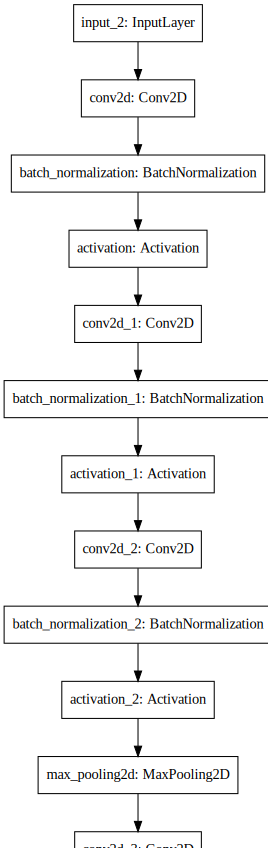

In [46]:
SVG(tf.keras.utils.model_to_dot(Model(model.layers[0].input, model.layers[0].layers[11].output), dpi=70).create(prog='dot', format='svg'))

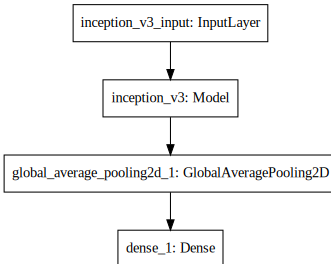

In [47]:
SVG(tf.keras.utils.model_to_dot(model, dpi=70).create(prog='dot', format='svg'))

In [48]:
history = model.fit(train_dataset,
                    epochs=EPOCHS,
                    callbacks=[lr_schedule],
                    steps_per_epoch=STEPS_PER_EPOCH,
                    validation_data=valid_dataset)


Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/20
12/12 [==============================] - 47s 4s/step - loss: 1.4670 - categorical_accuracy: 0.1022 - val_loss: 1.3866 - val_categorical_accuracy: 0.3212 - lr: 1.0000e-05

Epoch 00002: LearningRateScheduler reducing learning rate to 8.8e-05.
Epoch 2/20
12/12 [==============================] - 15s 1s/step - loss: 0.8272 - categorical_accuracy: 0.7148 - val_loss: 0.9741 - val_categorical_accuracy: 0.6022 - lr: 8.8000e-05

Epoch 00003: LearningRateScheduler reducing learning rate to 0.000166.
Epoch 3/20
12/12 [==============================] - 30s 3s/step - loss: 0.3058 - categorical_accuracy: 0.8978 - val_loss: 2.2831 - val_categorical_accuracy: 0.5949 - lr: 1.6600e-04

Epoch 00004: LearningRateScheduler reducing learning rate to 0.000244.
Epoch 4/20
12/12 [==============================] - 31s 3s/step - loss: 0.2067 - categorical_accuracy: 0.9342 - val_loss: 0.7152 - val_categorical_accuracy: 0.8285 - lr: 2.4

In [49]:
display_training_curves(
    history.history['categorical_accuracy'], 
    history.history['val_categorical_accuracy'], 
    'accuracy')

In [50]:
probs_incepv3 = model.predict(test_dataset, verbose=1)
sub.loc[:, 'healthy':] = probs_incepv3
sub.to_csv('submission_incepv3.csv', index=False)
sub.head()

#LB:-0.95988

15/15 [==============================] - 32s 2s/step


image_id       healthy  multiple_diseases          rust          scab
0   Test_0  7.717676e-07       3.268695e-04  9.996722e-01  2.643130e-07
1   Test_1  1.680849e-05       1.890082e-04  9.997934e-01  8.384753e-07
2   Test_2  6.306119e-09       7.265621e-07  2.275838e-08  9.999993e-01
3   Test_3  9.999816e-01       8.590070e-08  1.742717e-05  8.801175e-07
4   Test_4  1.822488e-08       3.365194e-04  9.996631e-01  3.837790e-07

<h2>3. ResNet</h2>

In [51]:
with strategy.scope():
    model = tf.keras.Sequential([ResNet50V2(input_shape=(512, 512, 3),
                                             weights='imagenet',
                                             include_top=False),
                                 L.GlobalAveragePooling2D(),
                                 L.Dense(train_labels.shape[1],
                                         activation='softmax')])
        
    model.compile(optimizer='adam',
                  loss = 'categorical_crossentropy',
                  metrics=['categorical_accuracy'])
    model.summary()

94674944/94668760 [==============================] - 2s 0us/step
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Model)           (None, 16, 16, 2048)      23564800  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 8196      
Total params: 23,572,996
Trainable params: 23,527,556
Non-trainable params: 45,440
_________________________________________________________________


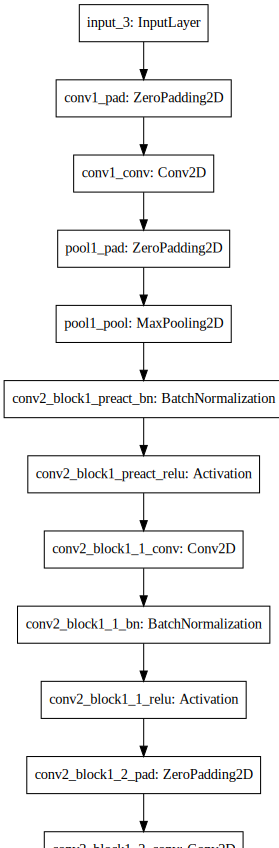

In [52]:
SVG(tf.keras.utils.model_to_dot(Model(model.layers[0].input, model.layers[0].layers[11].output), dpi=70).create(prog='dot', format='svg'))

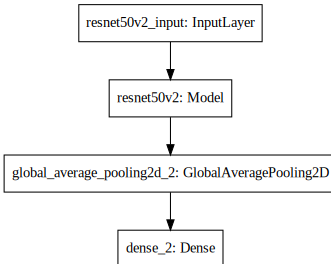

In [53]:
SVG(tf.keras.utils.model_to_dot(model, dpi=70).create(prog='dot', format='svg'))

In [54]:
history = model.fit(train_dataset,
                    epochs=EPOCHS,
                    callbacks=[lr_schedule],
                    steps_per_epoch=STEPS_PER_EPOCH,
                    validation_data=valid_dataset)


Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/20
12/12 [==============================] - 41s 3s/step - loss: 1.4326 - categorical_accuracy: 0.3327 - val_loss: 1.2411 - val_categorical_accuracy: 0.3832 - lr: 1.0000e-05

Epoch 00002: LearningRateScheduler reducing learning rate to 8.8e-05.
Epoch 2/20
12/12 [==============================] - 13s 1s/step - loss: 0.7955 - categorical_accuracy: 0.7279 - val_loss: 1.2161 - val_categorical_accuracy: 0.5547 - lr: 8.8000e-05

Epoch 00003: LearningRateScheduler reducing learning rate to 0.000166.
Epoch 3/20
12/12 [==============================] - 32s 3s/step - loss: 0.3447 - categorical_accuracy: 0.8796 - val_loss: 3.2590 - val_categorical_accuracy: 0.5438 - lr: 1.6600e-04

Epoch 00004: LearningRateScheduler reducing learning rate to 0.000244.
Epoch 4/20
12/12 [==============================] - 34s 3s/step - loss: 0.2030 - categorical_accuracy: 0.9323 - val_loss: 3.4862 - val_categorical_accuracy: 0.5912 - lr: 2.4

In [55]:
display_training_curves(
    history.history['categorical_accuracy'], 
    history.history['val_categorical_accuracy'], 
    'accuracy')

In [56]:
probs_resnet = model.predict(test_dataset, verbose=1)
sub.loc[:, 'healthy':] = probs_resnet
sub.to_csv('submission_resnet.csv', index=False)
sub.head()

#LB:-0.94379

15/15 [==============================] - 34s 2s/step


image_id       healthy  multiple_diseases      rust          scab
0   Test_0  5.039331e-09       4.998544e-09  1.000000  3.126077e-09
1   Test_1  1.535553e-05       1.948416e-06  0.999982  4.663645e-07
2   Test_2  2.505322e-05       2.419137e-06  0.000032  9.999405e-01
3   Test_3  9.998115e-01       6.261050e-07  0.000185  2.515739e-06
4   Test_4  9.934590e-13       1.892987e-09  1.000000  2.971733e-11

<h2>4. InceptionResNet</h2>

In [ ]:
with strategy.scope():
    model = tf.keras.Sequential([InceptionResNetV2(input_shape=(512, 512, 3),
                                             weights='imagenet',
                                             include_top=False),
                                 L.GlobalAveragePooling2D(),
                                 L.Dense(train_labels.shape[1],
                                         activation='softmax')])
        
    model.compile(optimizer='adam',
                  loss = 'categorical_crossentropy',
                  metrics=['categorical_accuracy'])
    model.summary()

In [ ]:
SVG(tf.keras.utils.model_to_dot(Model(model.layers[0].input, model.layers[0].layers[11].output), dpi=70).create(prog='dot', format='svg'))

In [ ]:
SVG(tf.keras.utils.model_to_dot(model, dpi=70).create(prog='dot', format='svg'))

In [ ]:
history = model.fit(train_dataset,
                    epochs=EPOCHS,
                    callbacks=[lr_schedule],
                    steps_per_epoch=STEPS_PER_EPOCH,
                    validation_data=valid_dataset)

In [ ]:
display_training_curves(
    history.history['categorical_accuracy'], 
    history.history['val_categorical_accuracy'], 
    'accuracy')

In [ ]:
probs_incepres = model.predict(test_dataset, verbose=1)
sub.loc[:, 'healthy':] = probs_incepres
sub.to_csv('submission_incepres.csv', index=False)
sub.head()

#LB:-0.96181

<h2>5. Ensembling</h2>

In [ ]:
ensemble_1, ensemble_2, ensemble_3 = [sub]*3

# probs_incepv3

ensemble_1.loc[:, 'healthy':] = 0.50*probs_dnn + 0.50*probs_incepres
ensemble_2.loc[:, 'healthy':] = 0.75*probs_dnn + 0.20*probs_incepres + 0.05*probs_incepv3
ensemble_3.loc[:, 'healthy':] = 0.80*probs_dnn + 0.20*probs_incepres

ensemble_1.to_csv('submission_ensemble_1.csv', index=False) #LB :-0.96970
ensemble_2.to_csv('submission_ensemble_2.csv', index=False) #LB :-0.96970
ensemble_3.to_csv('submission_ensemble_3.csv', index=False) #LB :-0.96970

<h1>References</h1>

[https://www.kaggle.com/tarunpaparaju/plant-pathology-2020-eda-models/notebook](http://)

https://www.kaggle.com/pestipeti/eda-plant-pathology-2020